<a href="https://colab.research.google.com/github/opherdonchin/ModelsOfTheMotorSystems2021-2/blob/master/HW2_RK_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ypstruct

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ypstruct: filename=ypstruct-0.0.2-py3-none-any.whl size=2971 sha256=bf3fa07966c2b42431e8039a73bd1545995a49ceeaddad6a63082c66e5d269cd
  Stored in directory: /root/.cache/pip/wheels/62/c0/62/97e51a118545a181245d8111048d46ad4fbd0c0078c6804218
Successfully built ypstruct


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy.stats import norm
from ypstruct import *

plt.rcParams['font.size'] = '16'


# Homework 2

## Problem 1
Generate the following plots to match the plots in the lecture slides. Most
of the equations are taken from Thelen 2003 or from Buchanan 2004, if you
need help, although the notation is a little different.

### a.	Active force length curve

See slide 25 for equations

Text(0.5, 1.0, 'Active force length curve')

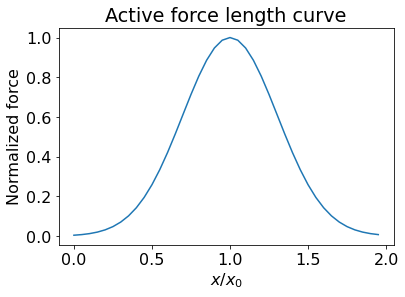

In [3]:
xNorm = np.arange(start=0, stop=2, step=0.05)
w = 0.185

def x2Factive(xNorm=xNorm, w=w):
    return np.exp(-pow(xNorm-1,2) / w)

alpha = x2Factive(xNorm)

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.plot(xNorm, alpha)
ax.set_xlabel(r'$x / x_0$')
ax.set_ylabel(r'Normalized force')
ax.set_title('Active force length curve')

### b.	Passive force length curve

See slide 26 for equations

Text(0.5, 1.0, 'Passive force length curve')

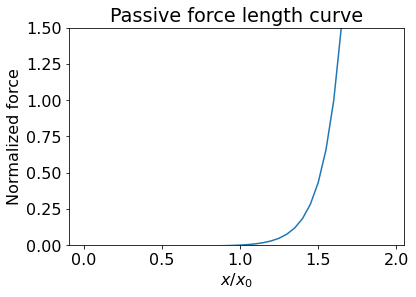

In [4]:
xNorm = np.arange(start=0, stop=2, step=0.05)
k_pe = 5
e_pe = 0.6

def x2Fpassive(xNorm=xNorm, k_pe=k_pe, e_pe=e_pe):
    return (np.exp(k_pe*(xNorm-1)/e_pe)-1) / (np.exp(k_pe)-1)

F_pe = x2Fpassive(xNorm)

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.plot(xNorm, F_pe)
ax.set_xlabel(r'$x / x_0$')
ax.set_ylabel(r'Normalized force')
ax.set_ylim(0, 1.5)
ax.set_title('Passive force length curve')

### c.	Velocity force curve

See slide 28 for equations

Text(0.5, 1.0, 'Velocity force curve')

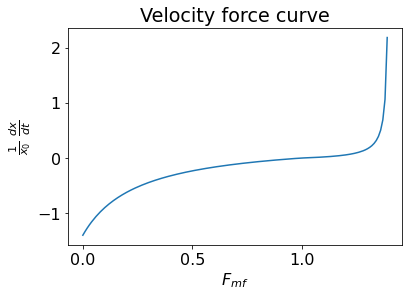

In [5]:
F_mf = np.arange(start=0, stop=1.4, step=0.01)
gamma = 1
alpha = 1
Fmax_mf = 1.4
A_f = 0.25

def F_mf2xdot(F_mf, gamma=gamma, alpha=alpha,
              Fmax_mf=Fmax_mf, A_f=A_f):
    b = np.where(F_mf < gamma*alpha,
                 gamma*alpha + F_mf / A_f,
                 (2+2/A_f)*(gamma*alpha*Fmax_mf - F_mf)/(Fmax_mf - 1)
                 )
    return (0.25+0.75*gamma)*Fmax_mf*(F_mf-gamma*alpha)/b

xdot = F_mf2xdot(F_mf)

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.plot(F_mf, xdot)
ax.set_xlabel(r'$F_{mf}$')
ax.set_ylabel(r'$\frac{1}{x_0} ~ \frac{dx}{dt}$')
ax.set_title('Velocity force curve')

### d.	Force velocity curve

These are the same equations as part (c) but with the axes flipped

Text(0.5, 1.0, 'Force velocity curve')

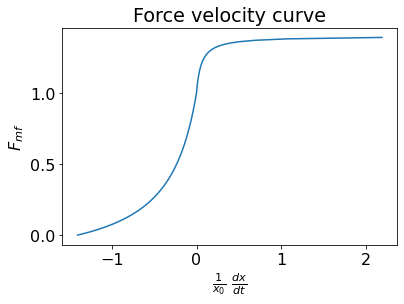

In [6]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.plot(xdot, F_mf)
ax.set_xlabel(r'$\frac{1}{x_0} ~ \frac{dx}{dt}$')
ax.set_ylabel(r'$F_{mf}$')
ax.set_title('Force velocity curve')

### e.	Tendon strain curve

See slide 32 for equations

Text(0.5, 1.0, 'Tendon strain curve')

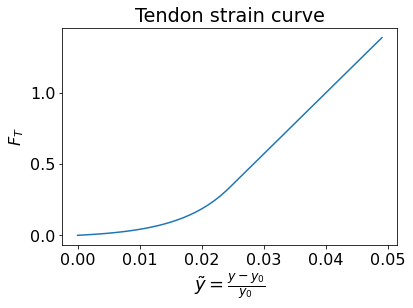

In [7]:
yNorm = np.arange(start=0, stop=0.05, step=0.001)
FtoeT = 0.33
ktoe = 3.0
e0T = 0.04
etoeT = 0.609*e0T
klin = 1.712 / e0T

def y2FTendon(yNorm=yNorm,
              FtoeT=FtoeT, ktoe=ktoe, e0T=e0T, etoeT=etoeT, klin=klin):
    return np.where(yNorm < etoeT,
             FtoeT*(np.exp(ktoe*yNorm/etoeT)-1)/(np.exp(ktoe)-1),
             klin*(yNorm-etoeT)+FtoeT
             )

FT = y2FTendon(yNorm)

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.plot(yNorm, FT)
ax.set_xlabel(r'$\tilde{y} = \frac{y-y_0}{y_0}$', fontsize=18)
ax.set_ylabel(r'$F_{T}$')
ax.set_title('Tendon strain curve')


### f.	Activation dynamics

See slide 15 for equations

Here we have a differential equation, so we need to step it forward through time. We can
use the `odeint` function to do this as introduced in the "in class" exercise from the
beginning of the course.

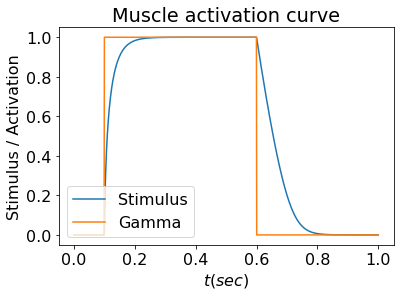

In [8]:
tRange = np.linspace(start=0.0, stop=1.0, num=1000)
tau_act = 0.015
tau_deact = 0.05
gamma_init = 0.0

def STIM(t):
    return np.where((0.1 < t) & (t < 0.6), 1, 0)

# In this function definition, STIM has to be a function
def Stim2Gamma(tRange=tRange, STIM=STIM,
               gamma_init = gamma_init,
               tau_act=tau_act, tau_deact=tau_deact):

    def activation(gamma, t):
        tau = np.where(STIM(t) < gamma, tau_deact*(0.5+1.5*gamma), tau_act*(0.5+1.5*gamma))
        dgamma_dt = (STIM(t) - gamma)/tau
        return dgamma_dt

    gamma = odeint(activation, gamma_init, tRange)
    return gamma

gamma = Stim2Gamma(tRange, STIM, gamma_init)

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.plot(tRange, gamma)
ax.plot(tRange, STIM(tRange))
ax.set_xlabel(r'$t (sec)$')
ax.set_ylabel('Stimulus / Activation')
ax.set_title('Muscle activation curve')
ax.legend(['Stimulus', 'Gamma'], loc="lower left")


## Problem 2

Please program a Hill-type model as described in the
lecture and replicate the three graphs in the slides

### a.	500 ms stimulus at 0.1 s

We just do this by stepping through the steps in slides 37-39

In [16]:
def update_state(t,s: struct, STIM, p):
  s1 = s.copy()
  xNorm = s.x/p.x0
  s1.alpha = x2Factive(xNorm)
  s1.y = p.Lmt - s.x*np.cos(p.theta)
  yNorm = (s1.y-p.y0)/p.y0
  s1.Ft = y2FTendon(yNorm)
  Fpassive = x2Fpassive(xNorm)
  F_mf = (s1.Ft - Fpassive*np.cos(p.theta)) / np.cos(p.theta)

  # Step 2 / slide 38
  tau_gamma = 0.5+1.5*s1.gamma
  tau = p.tau_act*tau_gamma if STIM(t) > s.gamma else p.tau_deact*tau_gamma
  s1.gammadot =  (STIM(t)-s.gamma)/tau

  xdot_norm = F_mf2xdot(F_mf, gamma=s.gamma, alpha=s1.alpha)
  s1.xdot = x0*xdot_norm

  return s1

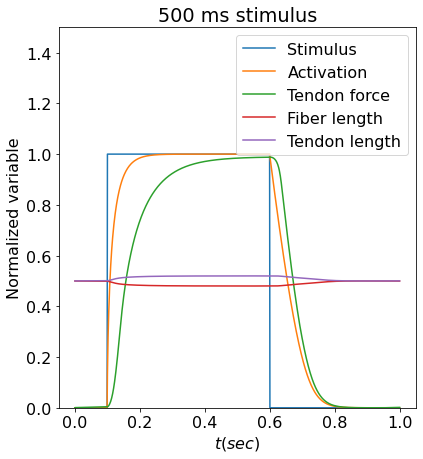

In [21]:
tRange = np.linspace(start=0.0, stop=1.0, num=1000)
gamma_init = 0.00001

def STIM(t):
    return np.where((0.1<t) & (t<0.6), 1, 0)

p = struct()
p.x0 = 0.5
p.Lmt = 1.0
p.theta = 0
p.y0 = 0.5
p.tau_act = tau_act
p.tau_deact = tau_deact

state = struct()
state.x = p.x0
state.xdot = 0
state.y = p.Lmt - state.x*np.cos(p.theta)
state.alpha = 0
state.Ft = 0
state.gamma = gamma_init
state.gammadot = 0

def isometric_hill_model(tRange=tRange, initial_state = state, STIM=STIM, gamma_init=gamma_init):
    state_list = list()
    state = initial_state
    dt = tRange[1]-tRange[0]

    for t in tRange:
      state = update_state(t, state, STIM, p)
      state.gamma = state.gamma + state.gammadot*dt
      state.x = state.x + state.xdot*dt
      state_list.append(state)

    return state_list

states = isometric_hill_model(tRange=tRange,
                         STIM=STIM, gamma_init=gamma_init)

fig, ax = plt.subplots(figsize=[6.4, 7])
fig.patch.set_facecolor('white')
ax.plot(tRange, [STIM(t) for t in tRange])
ax.plot(tRange, [s.gamma for s in states])
ax.plot(tRange, [s.Ft for s in states])
ax.plot(tRange, [s.x for s in states])
ax.plot(tRange, [s.y for s in states])
ax.set_ylim(0, 1.5)
ax.set_xlabel(r'$t (sec)$')
ax.set_ylabel('Normalized variable')
ax.set_title('500 ms stimulus')
ax.legend(['Stimulus', 'Activation', 'Tendon force', 'Fiber length', 'Tendon length'],
          loc="upper right")


In [47]:
tRange = np.linspace(start=0.0, stop=1.0, num=1000)
gamma_init = 0.00001

def STIM(t):
    return np.where((0.1<t) & (t<0.6), 1, 0)

p = struct()
p.x0 = 0.5
p.Lmt = 1.0
p.theta = 0
p.y0 = 0.5
p.tau_act = tau_act
p.tau_deact = tau_deact

state = struct()
state.x = p.x0
state.xdot = 0
state.y = p.Lmt - state.x*np.cos(p.theta)
state.alpha = 0
state.Ft = 0
state.gamma = gamma_init
state.gammadot = 0

def isometric_hill_model(tRange=tRange, state_init = state, STIM=STIM, gamma_init=gamma_init):

    def x2dx(t, svec):
      s = struct()
      s.gamma = svec[0]
      s.x = svec[1]
      s1 = update_state(t, s, STIM, p)
      return [s1.gammadot, s1.xdot]

    # ode_states = odeint(x2dx, np.array([state_init.gamma, state_init.x]), tRange)
    ode_states = solve_ivp(x2dx, tRange[[0,-1]], [state_init.gamma, state_init.x], method='RK45', t_eval=tRange)
    state_list = list()
    for t,gamma, x in zip(ode_states.t, ode_states.y[0], ode_states.y[1]):
      s = struct()
      s.gamma = gamma
      s.x = x
      state_list.append(update_state(t, s, STIM, p))
    return state_list

states = isometric_hill_model(tRange=tRange,
                         STIM=STIM, gamma_init=gamma_init)



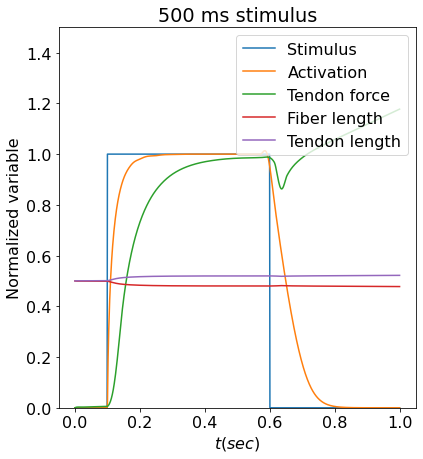

In [48]:
def plot_isometric_hill_model(tRange, states, STIM):
  fig, ax = plt.subplots(figsize=[6.4, 7])
  fig.patch.set_facecolor('white')
  ax.plot(tRange, [STIM(t) for t in tRange])
  ax.plot(tRange, [s.gamma for s in states])
  ax.plot(tRange, [s.Ft for s in states])
  ax.plot(tRange, [s.x for s in states])
  ax.plot(tRange, [s.y for s in states])
  ax.set_ylim(0, 1.5)
  ax.set_xlabel(r'$t (sec)$')
  ax.set_ylabel('Normalized variable')
  ax.set_title('500 ms stimulus')
  ax.legend(['Stimulus', 'Activation', 'Tendon force', 'Fiber length', 'Tendon length'],
            loc="upper right")

plot_isometric_hill_model(tRange, states, STIM)

### b.	5 ms stimulus at 0.1

In [49]:
tRange = np.linspace(start=0.0, stop=1.0, num=50000)

def STIM(t):
    return np.where((0.1<t) & (t<0.105), 1, 0)

states = isometric_hill_model(tRange=tRange,
                         STIM=STIM, gamma_init=gamma_init)



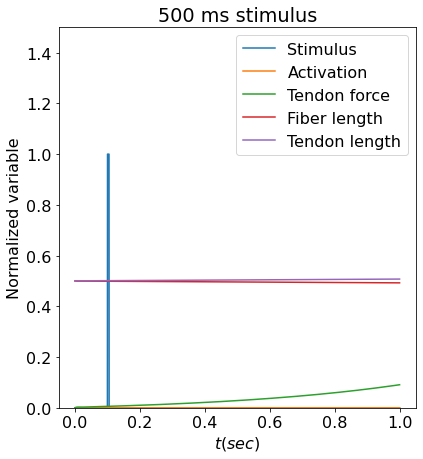

In [50]:
plot_isometric_hill_model(tRange, states, STIM)

### c.	Constant stumulus at 0.6

In [ ]:
tRange = np.linspace(start=0.0, stop=1.0, num=1000)

STIM = np.zeros(len(tRange))
STIM[0.1 < tRange] = 0.6

h = isometric_hill_model(tRange=tRange,
                         STIM=STIM, gamma_init=gamma_init)

fig,ax = plt.subplots(figsize=[6.4, 7])
fig.patch.set_facecolor('white')
ax.plot(tRange, STIM)
ax.plot(tRange, h['gamma'])
ax.plot(tRange, h['Ft'])
ax.plot(tRange, h['x'])
ax.plot(tRange, h['y'])
ax.set_ylim(0, 1.5)
ax.set_xlabel(r'$t (sec)$')
ax.set_ylabel('Normalized variable')
ax.set_title('500 ms stimulus')
ax.legend(['Stimulus', 'Activation', 'Tendon force', 'Fiber length', 'Tendon length'],
          loc="upper right")

This graph doesn't show the oscillations that we see in teh graph in the lecture. I'm not
really sure where they are coming from.